In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import numpy as np

# Because the Torch split method is absurd 
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler

In [2]:
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

    torch.cuda.set_device(0)
    print(f"Using GPU: {torch.cuda.current_device()} - {torch.cuda.get_device_name(torch.cuda.current_device())}")

    device = torch.device("cuda:0")

    print("Successful GPU connect")
else:
    device = torch.device('cpu')
    print("Using CPU")

device = torch.device('cpu')

Using CPU


In [3]:
df = pd.read_csv(r"./heart.csv")
df.head()

assert df['HeartDisease'].isin([0, 1]).all(), "Target column contains non-binary values"

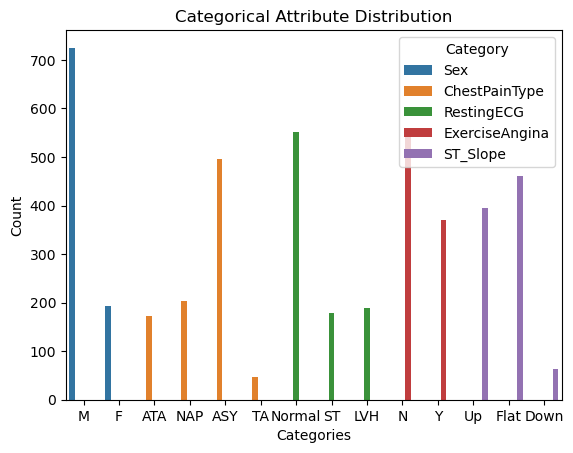

In [4]:
categorical_attributes = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

df_cat_melted = pd.melt(df[categorical_attributes], var_name='Category', value_name='Value')

# Plotting
plt.figure()
sns.countplot(data=df_cat_melted, x='Value', hue='Category')
plt.title('Categorical Attribute Distribution')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

c:\Users\vboy7\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


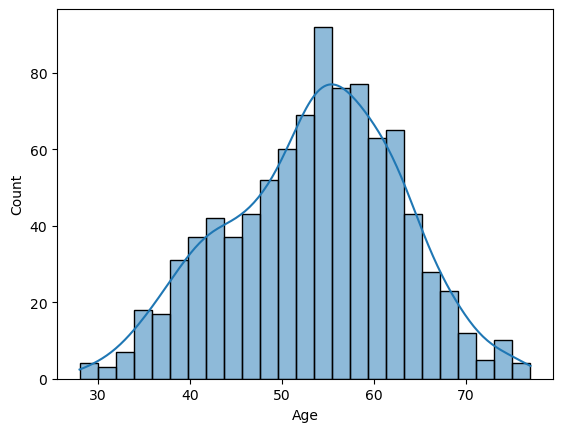

In [5]:
sns.histplot(data=df, x='Age', bins=25, kde=True)
plt.show()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
# Categorical to numerical for future embedding
df['Sex'] = df['Sex'].astype('category').cat.codes
df['ChestPainType'] = df['ChestPainType'].astype('category').cat.codes
df['RestingECG'] = df['RestingECG'].astype('category').cat.codes
df['ExerciseAngina'] = df['ExerciseAngina'].astype('category').cat.codes
df['ST_Slope'] = df['ST_Slope'].astype('category').cat.codes

scaler = StandardScaler()
attrs = df.columns[df.columns != 'HeartDisease']
df[attrs] = scaler.fit_transform(df[attrs])

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,0.515952,0.229032,0.410909,0.825070,-0.551341,0.017255,1.382928,-0.823556,-0.832432,1.052114,0
1,-0.478484,-1.938163,1.275059,1.491752,-0.171961,-0.551341,0.017255,0.754157,-0.823556,0.105664,-0.596078,1
2,-1.751359,0.515952,0.229032,-0.129513,0.770188,-0.551341,1.601219,-1.525138,-0.823556,-0.832432,1.052114,0
3,-0.584556,-1.938163,-0.816995,0.302825,0.139040,-0.551341,0.017255,-1.132156,1.214246,0.574711,-0.596078,1
4,0.051881,0.515952,1.275059,0.951331,-0.034755,-0.551341,0.017255,-0.581981,-0.823556,-0.832432,1.052114,0


In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(11, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        logits = torch.sigmoid(logits)
        return logits

In [9]:
model = Model().to(device)
print(model)

Model(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=11, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=1, bias=True)
  )
)


In [10]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_train = X_train.clone().detach().to(device)
y_train = y_train.clone().detach().to(device)

X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)
X_test = X_train.clone().detach().to(device)
y_test = y_train.clone().detach().to(device)

In [11]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train).squeeze()
    loss = criterion(outputs.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [5/200], Loss: 0.6452
Epoch [10/200], Loss: 0.5771
Epoch [15/200], Loss: 0.5077
Epoch [20/200], Loss: 0.4429
Epoch [25/200], Loss: 0.3923
Epoch [30/200], Loss: 0.3601
Epoch [35/200], Loss: 0.3420
Epoch [40/200], Loss: 0.3307
Epoch [45/200], Loss: 0.3218
Epoch [50/200], Loss: 0.3138
Epoch [55/200], Loss: 0.3063
Epoch [60/200], Loss: 0.2989
Epoch [65/200], Loss: 0.2917
Epoch [70/200], Loss: 0.2846
Epoch [75/200], Loss: 0.2777
Epoch [80/200], Loss: 0.2708
Epoch [85/200], Loss: 0.2640
Epoch [90/200], Loss: 0.2573
Epoch [95/200], Loss: 0.2508
Epoch [100/200], Loss: 0.2444
Epoch [105/200], Loss: 0.2381
Epoch [110/200], Loss: 0.2320
Epoch [115/200], Loss: 0.2261
Epoch [120/200], Loss: 0.2204
Epoch [125/200], Loss: 0.2148
Epoch [130/200], Loss: 0.2093
Epoch [135/200], Loss: 0.2038
Epoch [140/200], Loss: 0.1984
Epoch [145/200], Loss: 0.1930
Epoch [150/200], Loss: 0.1878
Epoch [155/200], Loss: 0.1826
Epoch [160/200], Loss: 0.1776
Epoch [165/200], Loss: 0.1726
Epoch [170/200], Loss: 0.1677


In [12]:
# Evaluate the model
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    outputs = model(X_test)
    predicted = outputs.round()
    
    y_true = y_test.cpu().numpy()
    y_pred = predicted.cpu().numpy()

y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9510
Precision: 0.9398
Recall: 0.9760
F1 Score: 0.9575


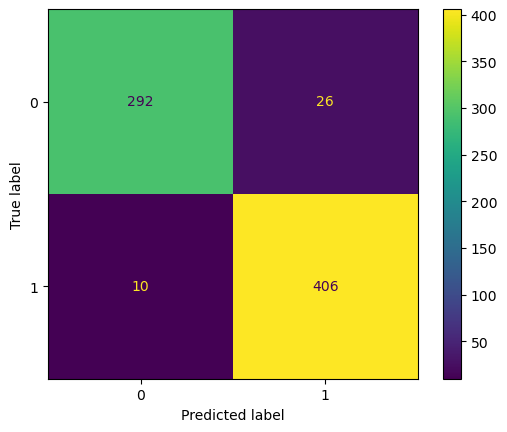

In [13]:
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()